# Assignment 1

DATASET (MNIST): http://yann.lecun.com/exdb/mnist/

Train 1 denoising and 1 contractive autoencoder on the MNIST dataset. It is up to you to decide how many layers and neurons in each layer and how many layers you want in the deep autoencoder. Show an accuracy comparison between the different autoencoders.

Then, experiment with what happens if you feed the autoencoders with a random noise image and then you apply the iterative gradient ascent process described in the lecture to see if the reconstruction converges to the data manifold. Confront the reconstructions created by the 2 different models and comment on the results.

In [44]:
import torch
import itertools as it

from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self,encoder_sizes,decoder_sizes):
        super(AutoEncoder, self).__init__()
        encoder_layers=[]
        for sx,dx in it.pairwise(encoder_sizes[:-1]):
            encoder_layers.append(nn.Linear(sx,dx))
            encoder_layers.append(nn.ReLU())
        encoder_layers.append(nn.Linear(encoder_sizes[-2],encoder_sizes[-1]))
        decoder_layers=[]
        for sx,dx in it.pairwise(decoder_sizes):
            decoder_layers.append(nn.Linear(sx,dx))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(
            *encoder_layers
        )
        self.decoder = nn.Sequential(
            *decoder_layers
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded.retain_grad()
        decoded = self.decoder(encoded)
        return encoded, decoded

In [45]:

import torchvision
import torchvision.transforms as transforms
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)


In [46]:
import matplotlib.pyplot as plt 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def train_denoising_ae(ae,data,n_epochs=10):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for sample in data:
            img, _ = sample
            img_noisy = img + 0.5 * torch.randn(img.size())
            img_noisy = img_noisy.view(-1, 28*28)
            img = img.view(-1, 28*28)
            optimizer.zero_grad()

            img=img.to(DEVICE)
            img_noisy=img_noisy.to(DEVICE)
            _, output = ae(img_noisy)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{loss.item():.4f}')
dae=AutoEncoder([28*28, 128, 64], [64, 128, 28*28]).to(DEVICE)
train_denoising_ae(dae,dataset,20)

epoch [1/20], loss:0.2297
epoch [2/20], loss:0.2284
epoch [3/20], loss:0.2279
epoch [4/20], loss:0.2275
epoch [5/20], loss:0.2273
epoch [6/20], loss:0.2269
epoch [7/20], loss:0.2269
epoch [8/20], loss:0.2268
epoch [9/20], loss:0.2268
epoch [10/20], loss:0.2268
epoch [11/20], loss:0.2267
epoch [12/20], loss:0.2268
epoch [13/20], loss:0.2266
epoch [14/20], loss:0.2267
epoch [15/20], loss:0.2266
epoch [16/20], loss:0.2266
epoch [17/20], loss:0.2266
epoch [18/20], loss:0.2266
epoch [19/20], loss:0.2266
epoch [20/20], loss:0.2266


In [48]:
def jacobian_penalty_term(hidden, inputs):
    jacobian = torch.autograd.grad(outputs=hidden, inputs=inputs,
                                   grad_outputs=torch.ones_like(hidden),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
    jacobian = jacobian.view(jacobian.size(0), -1)
    penalty_term = torch.norm(jacobian, p=2, dim=1)
    return penalty_term

def train_contractive_ae(ae,data,n_epochs=10,contractive_penalty=1e-4):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(ae.parameters(), lr=0.001)
    for epoch in range(n_epochs):
        for sample in data:
            img, _ = sample
            img = img.view(-1, 28*28).to(DEVICE)
            img.requires_grad = True
            optimizer.zero_grad()
            hidden, output = ae(img)
            loss = criterion(output, img) + contractive_penalty * jacobian_penalty_term(hidden, img)
            loss.backward()
            optimizer.step()
        print(f'epoch [{epoch + 1}/{n_epochs}], loss:{loss.item():.4f}')
#needed in order to compute the jacobian
dataset.requires_grad = True
cae=AutoEncoder([28*28, 128, 64], [64, 128, 28*28]).to(DEVICE)
train_contractive_ae(cae,dataset,20)

epoch [1/20], loss:0.2295
epoch [2/20], loss:0.2281
epoch [3/20], loss:0.2274
epoch [4/20], loss:0.2271
epoch [5/20], loss:0.2270
epoch [6/20], loss:0.2269
epoch [7/20], loss:0.2268
epoch [8/20], loss:0.2268
epoch [9/20], loss:0.2268
epoch [10/20], loss:0.2267
epoch [11/20], loss:0.2267
epoch [12/20], loss:0.2267
epoch [13/20], loss:0.2267
epoch [14/20], loss:0.2267
epoch [15/20], loss:0.2266
epoch [16/20], loss:0.2266
epoch [17/20], loss:0.2266
epoch [18/20], loss:0.2266
epoch [19/20], loss:0.2266
epoch [20/20], loss:0.2266


In [82]:
def generate_data_point(model, input_shape, num_iterations=100, step_size=1e-2):
    # Start with a random noise
    noise = torch.randn(input_shape).requires_grad_(True).to(DEVICE)
    noise.retain_grad()
    for i in range(num_iterations):
        # Forward pass through the encoder
        hidden = model.encoder(noise)

        # Calculate the gradient of the hidden activations with respect to the noise
        hidden.backward(torch.ones_like(hidden))
        # Perform gradient ascent
        with torch.no_grad():
            noise += step_size * noise.grad

        # Reset gradients
        model.zero_grad()
        noise.grad.zero_()

    # Pass the resulting activations through the decoder
    with torch.no_grad():
        new_data_point = model.decoder(hidden)

    return new_data_point

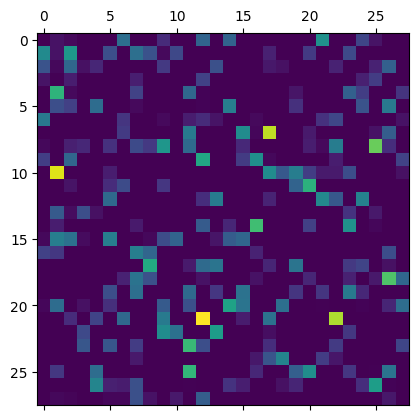

In [85]:
plt.matshow(generate_data_point(cae,28*28,10000,1e-3).view(28, 28).detach().cpu().numpy())